In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Polinomios Autoregresivos (Modelo ARX)

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas. Usando el modelo ARX:

![OL_LTID2](figuras/lti_arx.png)

Usando el modelo de ecuación de error tenemos que:

$$y[k] = -a_1y[k-1]-...-a_{n_a}y[k-{n_a}] + b_1u[k-1]+b_2u[k-2]+...+b_{n_b}u[k-{n_b}] + e[k]$$

El objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_1, b_2,...,b_{n_b}]^T$. Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[k] = \phi.\theta + e[k]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[k-1]&-y[k-2]&...&-y[k-{n_a}]&u[k-1]&u[k-2]&...&u[k-{n_b}]\end{bmatrix}$$

Recordar que del error se pueden introducir los polinomios autoregresivos del modelo ARX:

$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$

$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

Reorganizando entonces:

$$y[k]= \frac{B[z]}{A[z]}u[k] + \frac{1}{A[z]}e[k]$$

$$y[k] = G_e(z)u[k] + H_e(z)e[k]$$

El problema evidente en obtener estas funciones de transferencia estimadas es que se desconoce la naturaleza de la señal $e[k]$, por tanto la señal estimada se debe reconstruir a partir de la función G estimada y el escalón de entrada.

## Ejemplo 1:

Suponga que se realiza la medición de un sistema dinámico y que se mide la señal de la salida con un instrumento con valores de ruido aleatorio.

En un experimento de laboratorio se obtienen 2 respuestas al escalo usando diferentes magnitudes, con un sensor obteniendo un conjunto de valores $y_{n1}, y_{n2}$

Utilice el modelo ARX para determinar una función de transferencia estimada así:

$$G_e(z) = \frac{B(z)}{A(z)}$$



<AxesSubplot: xlabel='t', ylabel='yn'>

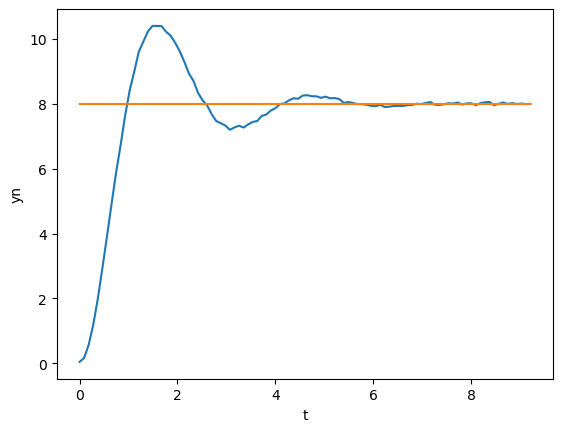

In [3]:
## Sistema de segundo orden en tiempo continuo
K1 = np.random.randint(1,10,dtype=int)
g = control.tf([9],[2,3,9])

#g = control.tf([4],[1,2,4])

# Señal de salida ideal "y" y entrada "u"
t,y = control.step_response(K1*g)
dt = t[1]-t[0]
N = len(t)
u = K1*np.ones(N);

## Ruido para simular la señal de salida capturada "yn"
r = 0.03
e = np.random.normal(0,r,size=N)
## Señal de medición de la salida
yn = y+e
## Ceros
z = np.zeros(N);

## Generando los datos para validar el MODELO
K2 = np.random.randint(1,10,dtype=int)
_,yv = control.step_response(K2*g,t)
## Ruido para las señales de entrenamiento
r = 0.01
e = np.random.normal(0,r,size=N)
# Datos para entrenamiento o validación
yv = yv+e
uv = K2*np.ones(N);


data = {'unos':np.ones(N),'yn':yn,'u':u,'t':t,'y1':z,'y2':z,'y3':z,'y4':z,'u1':z,'u2':z,'u3':z,'yv':yv,'uv':uv}
df = pd.DataFrame(data);

sns.lineplot(x = "t", y = "yn", data = df)
sns.lineplot(x = "t", y = "u", data = df)
#plt.legend(['Medición','Entrada'])

## Definir la matriz de regresión

Para estimar el modelo se debe usar la matriz de regresión lineal, involucrando estados anteriores de la salida y de la entrada.
$$\phi = \begin{bmatrix}-y[k-1]&u[k-1]&u[k-2]&u[k-3]\end{bmatrix}$$

In [4]:
## Crear las versiones resagadas de los datos y1, y2, y3, además de las entradas u,
## dependiendo el sistema que se quiera modelar

df.y1 = df.yn.shift(1)
df.y2 = df.yn.shift(2)
df.y3 = df.yn.shift(3)
df.y4 = df.yn.shift(4)

df.u1 = df.u.shift(1)
df.u2 = df.u.shift(2)
df.u3 = df.u.shift(3)

df = df.fillna(0)

## Creación del vector phi

phi = np.array([-df.y1,-df.y3,-df.y4,df.u1]).transpose()


## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$

La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad. Existirán tantos parámetros como columnas tenga la matriz de regresión.

In [5]:
# Parámetro ALPHA para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
alpha = 0.01
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-1.26394035,  0.12149219,  0.19479047,  0.05187697])

## Determinando los polinomios autoregresivos
$$A(z) = 1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}$$
$$B(z) = b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}$$

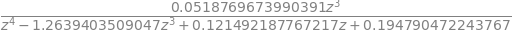

In [6]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-3 +theta[2]*z**-4   
B = theta[3]*z**-1

## Calcular la función de transferencia G y H en simbólica
G = B/A
G = G.simplify()
G

## Construir la función estimada en tiempo discreto
$$G_e(z)=\frac{B(z)}{A(z)} = \frac{b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-n_b}}{1+a_1z^{-1}+...+a_{n_a}z^{-n_a}}$$

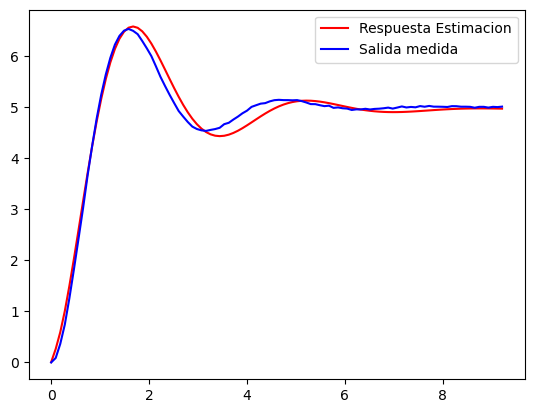

In [7]:
## Se crea el sistema estimado
G_e = control.tf([theta[3],0,0,0],[1,theta[0],0,theta[1],theta[2]],dt)

## Se determina la respuesta estimada al escalón con entrada de validación (K2)
Ke = K2
_,ye = control.step_response(Ke*G_e,t)


## Graficando las funciones
plt.plot(t,ye,color = 'red')
plt.plot(t,yv,color = 'blue')
plt.legend(['Respuesta Estimacion','Salida medida'])

In [8]:
## Función de transferencia estimada G(z) y error cuadratico medio 
gd = control.c2d(g,dt)
ECM = np.sqrt(np.dot((yn-ye).transpose(),(yn-ye)))/len(yn)
print(ECM)

0.29801546873471985


array([[list([<matplotlib.lines.Line2D object at 0x000001F78FFC9420>]),
        list([<matplotlib.lines.Line2D object at 0x000001F78FFC96F0>])]],
      dtype=object)

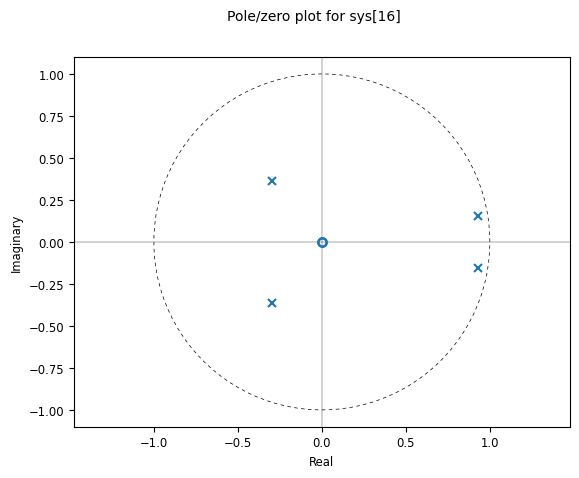

In [9]:
control.pzmap(G_e)

array([[list([<matplotlib.lines.Line2D object at 0x000001F79005C790>]),
        list([<matplotlib.lines.Line2D object at 0x000001F79005CA60>])]],
      dtype=object)

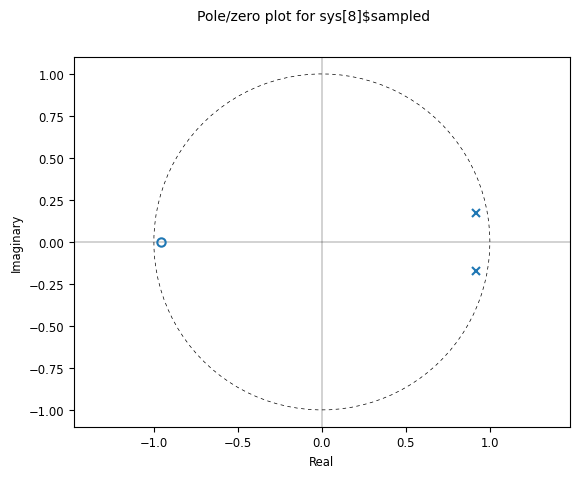

In [10]:
control.pzmap(gd)

## Validando el modelo obtenido

Para validar el modelo se utilizarán los datos de validación guardados en la señal yv cuya entrada fue de magnitud 6.
Se procede a reconstruir la señal dato por dato:

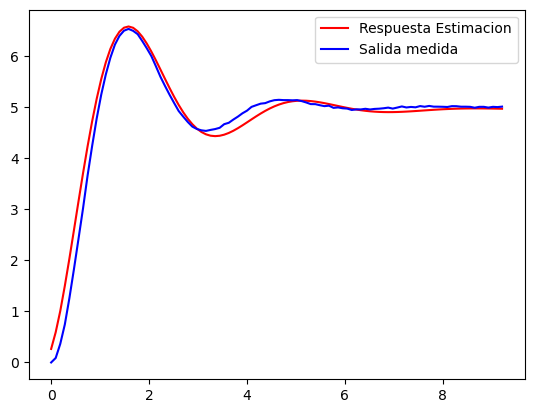

In [11]:
## Reconstruyendo el modelo a partir de ye2 = -df.y1,-df.y3,-df.y4,df.u1 y usando datos de validación
ye1 = np.zeros(len(t))
for k in range(len(t)):
    ye1[k] = -theta[0]*ye1[k-1]-theta[1]*ye1[k-3]-theta[2]*ye1[k-4]+theta[3]*uv[k-1] 

## Graficando las funciones
plt.plot(t,ye1,color = 'red')
plt.plot(t,df.yv,color = 'blue')
plt.legend(['Respuesta Estimacion','Salida medida'])
